# Group Analysis

### import modules

In [1]:
import os
import pickle

import nibabel as nib
from nilearn import plotting,image,input_data

import numpy as np
from scipy import stats
from sklearn import preprocessing,model_selection

import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

### get the tMaps

In [2]:
tList = np.array(['../data/raw/nii/%s'%x for x in os.listdir('../data/raw/nii/') if x.startswith('tMap_pat')])
tList.sort()

In [3]:
tList.shape

(783,)

In [ ]:
df = pd.DataFrame(tList)
df.columns = ['tIm']
df.index = [x.split('tMap_')[-1].split('.')[0] for x in df['tIm']]
df.tail()

### get clinical info

In [ ]:
clinDf = pd.read_csv('../data/raw/csv/clinData.csv',index_col=[0])
clinDf.tail()

In [6]:
# get only datasets for which tMaps and clinical infos exist
clinDf = pd.concat([clinDf,df],join='inner',axis=1)
clinDf = clinDf.dropna()

clinDf.sort_index(inplace=True)
clinDf['newName'] = clinDf.index
clinDf = clinDf.dropna()
clinDf.index = pd.MultiIndex.from_tuples([x.split('_') for x in clinDf.index])

In [ ]:
clinDf.tail()

In [8]:
clinDf.shape

(783, 5)

get rid of incomplete datasets

In [9]:
clinDf = clinDf[clinDf.n_vols==200]
clinDf = clinDf[clinDf.problems==0]

In [ ]:
clinDf.tail()

In [11]:
clinDf.shape

(783, 5)

### get wada infos

In [12]:
wadaDf = pd.read_csv('../data/raw/csv/wadaData.csv',index_col=[0])
wadaDf.sort_index(inplace=True)

In [13]:
wadaDf.shape

(65, 9)

In [ ]:
wadaDf.tail()

determine which patient has a wada test result; all of these have to move to the test set

In [15]:
for i in clinDf.index.levels[0]:
    if i in wadaDf.index:
        clinDf.set_value(i,'wada',True)
    else:
        clinDf.set_value(i,'wada',False)

In [ ]:
clinDf.tail()

In [17]:
'there are %s unique patients' % clinDf.groupby(level=0).count().shape[0]

'there are 712 unique patients'

### train-test split

In [18]:
# get number of cases for each clinical group
nGroup = clinDf.groupby('clin').count().max(axis=1)

Group sizes:

In [19]:
nGroup

clin
bilateral        75
inconclusive    134
left            527
right            47
dtype: int64

Relative Sizes of Groups:

In [20]:
# get number of all cases
nOverall = nGroup.sum()
# get proportion of each clinical group
propGroup = nGroup/nOverall

propGroup

clin
bilateral       0.095785
inconclusive    0.171137
left            0.673052
right           0.060026
dtype: float64

In [21]:
propGroup.round(2)

clin
bilateral       0.10
inconclusive    0.17
left            0.67
right           0.06
dtype: float64

Relative Sizes of the 3 main groups:

In [22]:
(nGroup.drop('inconclusive') / nGroup.drop('inconclusive').sum()).round(2)

clin
bilateral    0.12
left         0.81
right        0.07
dtype: float64

In [23]:
# the test set will be 1/3 of all cases
testSize = nOverall/3.
# the training set will be the rest
trainSize = nOverall-testSize
print nOverall,testSize,trainSize

783 261.0 522.0


#### starting condition for the training and test set  

first, the training data consist of all cases without wada
and the test data consist of all cases with wada.  
Then, we have to figure out how to move the non-wada cases
around, so we have adequately sized training and test sets.

In [ ]:
clinDf.tail()

In [25]:
trainSet = clinDf[clinDf['wada']==False]
testSet = clinDf[clinDf['wada']==True]

In [ ]:
testSet.tail()

In [27]:
# the target number of cases of each clinical group in the test set can now be computed
testGroup = (testSize*propGroup).round(0)
testGroup

clin
bilateral        25.0
inconclusive     45.0
left            176.0
right            16.0
dtype: float64

In [28]:
clinDf[clinDf['wada']==True].groupby('clin').count()

,n_vols,problems,tIm,newName,wada
clin,,,,,
bilateral,14,14,14,14,14
inconclusive,24,24,24,24,24
left,36,36,36,36,36
right,11,11,11,11,11


In [29]:
# starting conditions
testStartSize = testSet.groupby('clin').count()['newName']
trainStartSize = trainSet.groupby('clin').count()['newName']

# for each clinical group
for group in nGroup.index:
    # determine how many cases are missing, i.e. the discrepancy between
    # target (testGroup) and status quo (testStartSize)
    nMissing = int(testGroup[group]-testStartSize[group])
    if nMissing > 0:
        print group,testGroup[group],testStartSize[group],nMissing

        # get all training data of the clinical group
        thisDf = trainSet[trainSet['clin']==group]
        # get their names from the index
        thisIdx = list(thisDf.index)
        # shuffle the index, so we get a random sample
        np.random.shuffle(thisIdx)
        # get as many cases as we need (nMissing)
        addTestEntries = thisDf.loc[thisIdx[:nMissing]]

        # add the selected cases to the test set
        testSet = pd.concat([testSet,addTestEntries])
        # and remove the selected cases from the training set
        trainSet = trainSet.drop(thisIdx[:nMissing])
    elif nMissing == 0:
        print group,testGroup[group],testStartSize[group],nMissing
    else:
        thisDf = testSet[testSet['clin']==group]
        thisIdx = list(thisDf.index)
        np.random.shuffle(thisIdx)
        testSet = testSet.drop(thisIdx[nMissing:])
        print group,testGroup[group],testStartSize[group],nMissing

bilateral 25.0 14 11
inconclusive 45.0 24 21
left 176.0 36 140
right 16.0 11 5


#### show the result

In [30]:
trainNumResult = trainSet.groupby('clin').count()['newName']
trainNumResult/trainNumResult.sum()

clin
bilateral       0.095969
inconclusive    0.170825
left            0.673704
right           0.059501
Name: newName, dtype: float64

In [31]:
testNumResult = testSet.groupby('clin').count()['newName']
testNumResult/testNumResult.sum()

clin
bilateral       0.095420
inconclusive    0.171756
left            0.671756
right           0.061069
Name: newName, dtype: float64

### split the dataset

make an object to code the groups

In [32]:
myLabeler = preprocessing.LabelEncoder()
labels = clinDf.loc[:,'clin'].values
myLabeler.fit(labels)
print myLabeler.classes_

#pickle.dump(myLabeler, open('../models/myLabeler.p','wb') )

['bilateral' 'inconclusive' 'left' 'right']


later, when the code is re-run, we load the saved object:

In [33]:
myLabeler = pickle.load( open('../models/myLabeler.p','rb') )
print myLabeler.classes_

['bilateral' 'inconclusive' 'left' 'right']


we save the split, so we can re-use it for classification

In [34]:
my_nest = zip([x for x in trainSet.clin],['_'.join(x) for x in trainSet.index])
my_test = zip([x for x in testSet.clin],['_'.join(x) for x in testSet.index])

#pickle.dump(my_nest,open('../models/my_nest.p','wb'))
#pickle.dump(my_test,open('../models/my_test.p','wb'))

In [35]:
print "number of data in training set:", len(my_nest)
print "number of data in test set:", len(my_test)

number of data in training set: 521
number of data in test set: 262


if we want to re-run all code with the exact same settings, we need to load the split from file:

In [36]:
my_nest = pickle.load( open('../models/my_nest.p','rb') )
my_test = pickle.load( open('../models/my_test.p','rb') )

In [37]:
my_all = my_nest+my_test

In [ ]:
my_all[:5]

In [39]:
print 'number of data sets:',len(my_all)
print 'number of unique cases:',np.unique( np.array([x[1].split('_') for x in my_all])[:,0] ).shape[0]

number of data sets: 783
number of unique cases: 712


In [40]:
countDf = pd.DataFrame(my_all).groupby(0).count()
countDf

,1
0,
bilateral,75
inconclusive,134
left,527
right,47


In [41]:
percentDf = (countDf/countDf.sum()*100).round(0)
percentDf

,1
0,
bilateral,10.0
inconclusive,17.0
left,67.0
right,6.0


the sample consisted of {{ countDf.loc['left',1] }} left-lateralised ({{ int(percentDf.loc['left',1]) }}%), 
{{ countDf.loc['bilateral',1] }} bilateral ({{ int(percentDf.loc['bilateral',1]) }}%), 
{{ countDf.loc['right',1] }} right-lateralised ({{ int(percentDf.loc['right',1]) }}%) and 
{{ countDf.loc['inconclusive',1] }} inconclusive ({{ int(percentDf.loc['inconclusive',1]) }}%) cases. 

In [42]:
percentDropDf = (countDf.drop('inconclusive')/countDf.drop('inconclusive').sum()*100).round(0)
percentDropDf

,1
0,
bilateral,12.0
left,81.0
right,7.0


Excluding the inconclusive cases, the distribution of lateralisation was 
{{ int(percentDropDf.loc['left',1]) }}% left, 
{{ int(percentDropDf.loc['bilateral',1]) }}% bilateral and 
{{ int(percentDropDf.loc['right',1]) }}% right-lateralised.

In [43]:
len(my_nest)

521

In [44]:
len(my_test)

262

Only after training on {{ len(my_nest) }} fMRI sessions, the best parameter combinations were used to predict the held-out testing data set of {{ len(my_test) }} fMRI sessions. 

assert that split worked. If so, no patient number from training should repeat in testing (no output = good).

In [45]:
# for every patient id-date in the training set
for i in [x[1] for x in my_nest]:
    # see if it is in the test set
    if i in [x[1] for x in my_test]:
        # show duplicates
        print i

### define brain masker

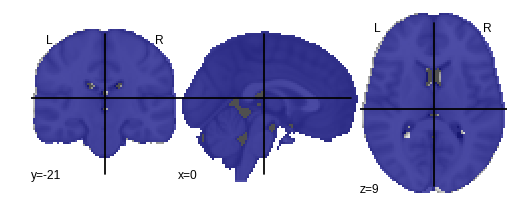

In [46]:
masker = input_data.NiftiMasker(mask_img='../data/external/MNI152_T1_2mm_brain_mask.nii.gz').fit()
plotting.plot_roi(masker.mask_img_);

### get the training data con files for group analysis

In [47]:
def makeMerge(dataDf,clinDf):
    
    # take only patient data for which there is both fMRI and clinical assessment (join=inner)
    mergeDf = pd.concat([dataDf,clinDf],axis=1,join='inner')
    # use the clinical assessment as the index
    mergeDf.index = [mergeDf.clin,mergeDf.index]
    # now that the index is updated, get rid of clinical data
    mergeDf.drop(clinDf.columns,axis=1,inplace=True)
    # get rid of patients for which the clinical assessment variable was empty
    mergeDf.drop('NaN',level=0,inplace=True)
    mergeDf.sort_index(inplace=True)
    
    return mergeDf

In [48]:
# get name-date combination as new index
clinDf.index = clinDf.newName
# get all con images
conList = np.array(['../data/raw/nii/%s'%x for x in os.listdir('../data/raw/nii/') if x.startswith('con')])
conList.sort()
# extract data from con images
data = masker.transform(conList)
df = pd.DataFrame(data)
df.index = [x.split('con_')[-1].split('.')[0] for x in conList]
# combine with clinical infos, so we get the clinical evaluation as a group variable
dataDf = makeMerge(df,clinDf)

/data/martin/frontSub/venv/lib/python2.7/site-packages/nilearn/image/resampling.py:491: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  copy=not input_img_is_string)
/data/martin/frontSub/venv/lib/python2.7/site-packages/nilearn/masking.py:95: RuntimeWarning: invalid value encountered in divide
  / np.sum(np.isfinite(extrapolation), axis=0))
/data/martin/frontSub/venv/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


In [49]:
dataDf.shape

(749, 228483)

In [ ]:
dataDf.loc[my_nest].tail()

### apply the split

for the group analysis and mask creation, we use only the training part of the data

In [51]:
nestDf = dataDf.loc[my_nest]
nestDf.sort_index(inplace=True)

In [52]:
nestDf.shape

(521, 228483)

check if there are missing values. If not, the number of rows in the .dropna() table should be the same as before:

In [53]:
nestDf.dropna().shape

(521, 228483)

In [54]:
for i in nestDf.index.levels[0]:
    print i, nestDf.loc[i].shape[0]

bilateral 50
inconclusive 89
left 351
right 31


In [ ]:
nestDf.tail()

### show the overall average

In [56]:
meanDf = nestDf.mean(axis=0)

In [57]:
meanIm = masker.inverse_transform(meanDf)

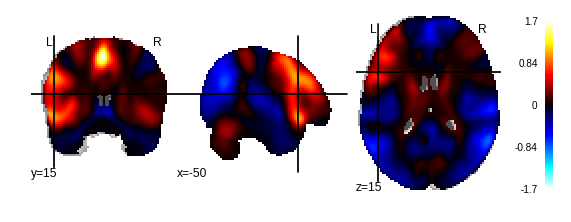

In [58]:
plotting.plot_stat_map(meanIm,cut_coords=(-50,15,15))

### show the overall standard deviation

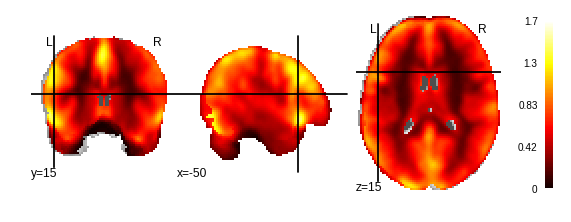

In [59]:
stdDf = nestDf.std(axis=0)
stdIm = masker.inverse_transform(stdDf)
plotting.plot_stat_map(stdIm,cut_coords=(-50,15,15))

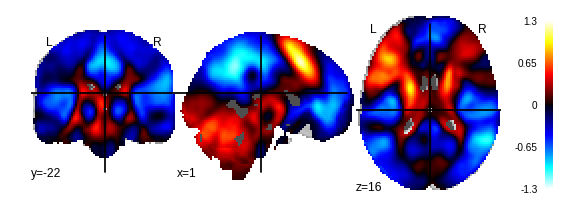

In [60]:
plotting.plot_stat_map( masker.inverse_transform(meanDf/stdDf) )

### show the overall t-Values

In [61]:
tVals = stats.ttest_1samp(nestDf,0)[0]

/data/martin/frontSub/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/data/martin/frontSub/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/data/martin/frontSub/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [62]:
tVals.shape

(228483,)

In [63]:
tIm = masker.inverse_transform(tVals)

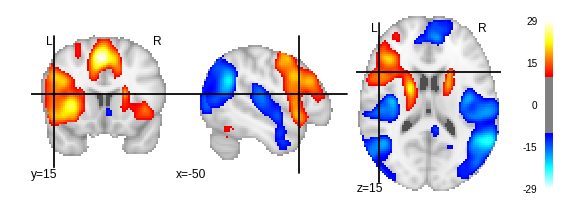

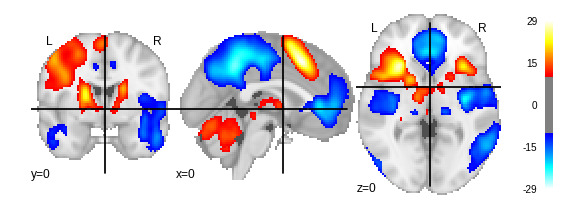

In [64]:
plotting.plot_stat_map(tIm,cut_coords=(-50,15,15),threshold=10)
plotting.plot_stat_map(tIm,cut_coords=(0,0,0),threshold=10)

### show the group-wise t-Values

In [65]:
for g in nestDf.index.levels[0]:
    thisDf = nestDf.loc[g]
    tVals = stats.ttest_1samp(thisDf,0)[0]
    tIm = masker.inverse_transform(tVals)
    tIm.to_filename('../data/processed/nii/tMapNest_%s.nii.gz'%g)

In [66]:
for g in nestDf.index.levels[0]:
    print g,nestDf.loc[g].shape[0]

bilateral 50
inconclusive 89
left 351
right 31


the first one is using different thresholds, so that given fixed effect size and power we determine the alpha needed to find an effect with the given sample size; this makes the thresholding much more comparable;  

here, we used GPower 2.1.9.2 with the following parameters:  

- ttest, difference from constant, one sample case  
- compute required alpha
- tails: two
- d: 0.5
- 1-beta: 0.8

the t-Values are:
- left n=351: 8.47
- bilateral n=50: 2.68
- right n=31: 1.93
- inconclusive n=89: 3.85

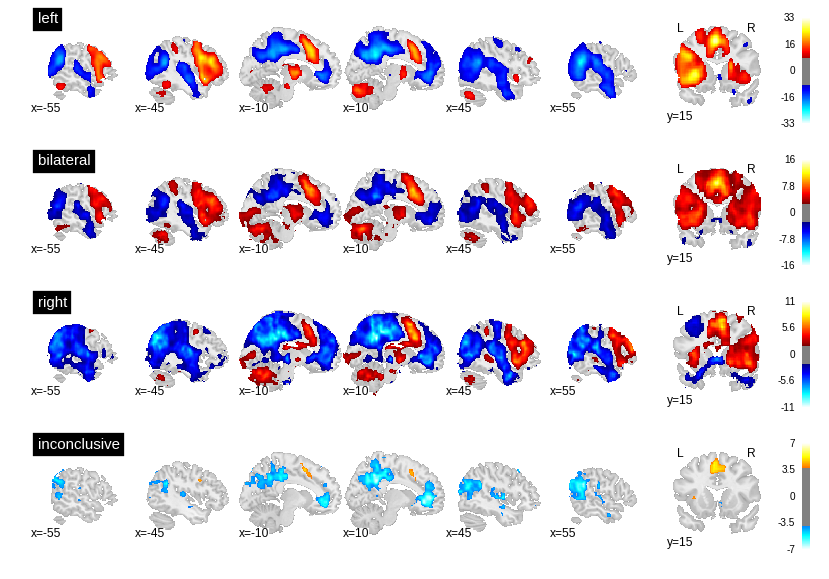

In [67]:
fig = plt.figure(figsize=(14,10))

for i,(group,thresh) in enumerate(zip(['left','bilateral','right','inconclusive'],
                                      [8.47,2.68,1.93,3.85])):

    tIm = '../data/processed/nii/tMapNest_%s.nii.gz'%group
    
    ax = plt.subplot2grid((4,10),(i,0),colspan=8)
    ax = plotting.plot_stat_map(tIm,
                           display_mode='x',
                           cut_coords=(-55,-45,-10,10,45,55),
                           threshold=thresh,
                           bg_img='../data/external/ch2better.nii.gz',
                           black_bg=False,
                           title=group,
                           colorbar=False,
                           axes=ax)
    
    ax = plt.subplot2grid((4,10),(i,8),colspan=2)
    ax = plotting.plot_stat_map(tIm,
                           display_mode='y',
                           cut_coords=([15]),
                           threshold=thresh,
                           bg_img='../data/external/ch2better.nii.gz',
                           black_bg=False,
                           colorbar=True,
                           #title=group,
                           axes=ax)
    
fig.savefig('../reports/figures/03-group-maps.png',dpi=300,bbox_inches='tight')
plt.show()

compare this to a fixed threshold:

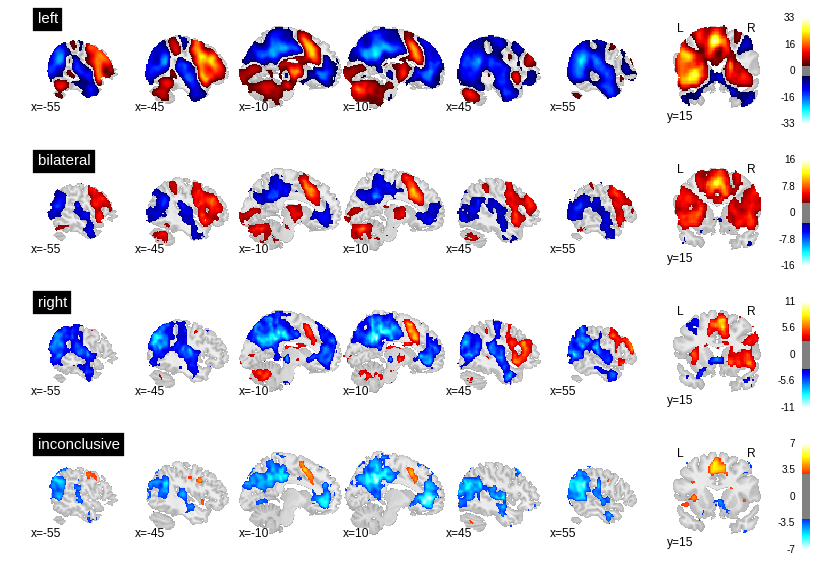

In [68]:
fig = plt.figure(figsize=(14,10))

for i,group in enumerate(['left','bilateral','right','inconclusive']):
    
    tIm = '../data/processed/nii/tMapNest_%s.nii.gz'%group
    
    ax = plt.subplot2grid((4,10),(i,0),colspan=8)
    ax = plotting.plot_stat_map(tIm,
                           display_mode='x',
                           cut_coords=(-55,-45,-10,10,45,55),
                           threshold=3,
                           bg_img='../data/external/ch2better.nii.gz',
                           black_bg=False,
                           title=group,
                           colorbar=False,
                           axes=ax)
    
    ax = plt.subplot2grid((4,10),(i,8),colspan=2)
    ax = plotting.plot_stat_map(tIm,
                           display_mode='y',
                           cut_coords=([15]),
                           threshold=3,
                           bg_img='../data/external/ch2better.nii.gz',
                           black_bg=False,
                           colorbar=True,
                           #title=group,
                           axes=ax)

plt.show()

### put everything on the left side

this is a function which flips the image across the x-axis (left-right); this is used to get the right-sided patient's activities on the left side

In [69]:
def makeFlip(pName):
    im = nib.load('../data/raw/nii/con_%s.nii'%pName)
    data,affine = im.get_data(),im.affine
    flipAffine = np.concatenate([ np.array([affine[0]*-1]), affine[1:] ])
    flipIm = nib.Nifti1Image(data,flipAffine)
    outIm = '../data/interim/nii/flipcon_%s.nii.gz'%pName
    flipIm.to_filename(outIm)
    return outIm

this is a function that only rewrites the image; this is used to keep the left-sided patient's activities on the left side

In [70]:
def makeNothing(pName):
    im = nib.load('../data/raw/nii/con_%s.nii'%pName)
    outIm = '../data/interim/nii/flipcon_%s.nii.gz'%pName
    im.to_filename(outIm)
    return outIm

do this (we ignore bilateral and inconclusive cases here)

In [71]:
for i in nestDf.loc['left'].index:
    makeNothing(i)
for i in nestDf.loc['right'].index:
    makeFlip(i)

#### check if this is correct

for left-sided patients, nothing should have changed:

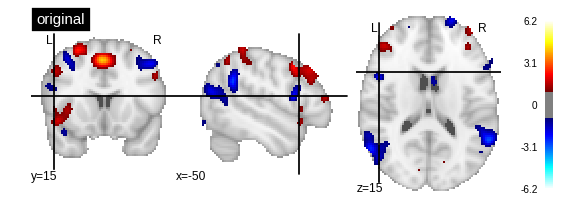

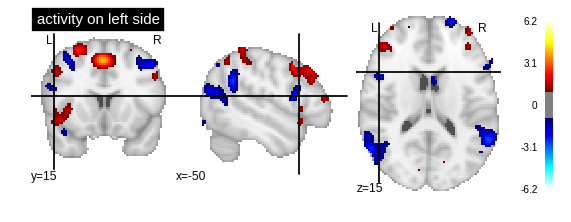

In [72]:
pName = nestDf.loc['left'].index[-20]
plotting.plot_stat_map('../data/raw/nii/con_%s.nii'%pName,cut_coords=(-50,15,15),threshold=1,title='original')
plotting.plot_stat_map('../data/interim/nii/flipcon_%s.nii.gz'%pName,cut_coords=(-50,15,15),threshold=1,title='activity on left side')

for right-sided patients, there should be a flip:

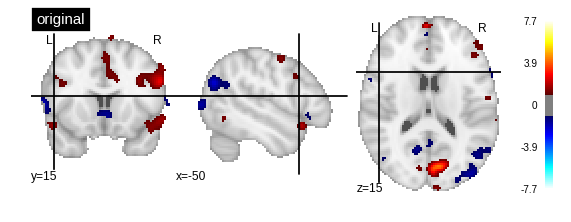

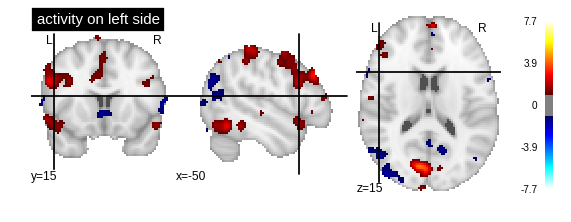

In [73]:
pName = nestDf.loc['right'].index[-8]
plotting.plot_stat_map('../data/raw/nii/con_%s.nii'%pName,cut_coords=(-50,15,15),threshold=1,title='original')
plotting.plot_stat_map('../data/interim/nii/flipcon_%s.nii.gz'%pName,cut_coords=(-50,15,15),threshold=1,title='activity on left side')

this is a function to flip the flipped images and compute the difference, so we get a laterality-value for each voxel

In [74]:
def makeDiff(pName):
    
    # get the image where the activity is on the left side
    left = '../data/interim/nii/flipcon_%s.nii.gz'%pName
    
    # make a flip
    im = nib.load(left)
    data,affine = im.get_data(),im.affine
    flipAffine = np.concatenate([ np.array([affine[0]*-1]), affine[1:] ])
    flipIm = nib.Nifti1Image(data,flipAffine)
    
    # make a difference
    data = ( masker.transform(left) - masker.transform(flipIm) )
    im = masker.inverse_transform(data)
    outIm = '../data/interim/nii/diffcon_%s.nii.gz'%pName
    im.to_filename(outIm)

    return outIm

In [75]:
for i in nestDf.loc['left'].index:
    makeDiff(i)
for i in nestDf.loc['right'].index:
    makeDiff(i)

## data of the laterality maps

get the data

In [76]:
conList = np.array(['../data/interim/nii/%s'%x for x in os.listdir('../data/interim/nii/') if x.startswith('diffcon')])
diffData = np.array([masker.transform(x)[-1] for x in conList])
diffDataDf = pd.DataFrame(diffData)
diffDataDf.index = [x.split('diffcon_')[-1].split('.')[0] for x in conList]

convolve with the clinical information

In [77]:
diffDataDf = makeMerge(diffDataDf,clinDf)
# make sure we only use training data
diffDataDf = diffDataDf.loc[my_nest].dropna(axis=0)

In [ ]:
diffDataDf.tail()

In [79]:
diffDataDf.shape

(382, 228483)

### compute group-level t-Values

In [80]:
tVals = stats.ttest_1samp(diffDataDf,0)[0]
tIm = masker.inverse_transform(tVals)
tIm.to_filename('../data/processed/nii/tMap_diff_values.nii.gz')

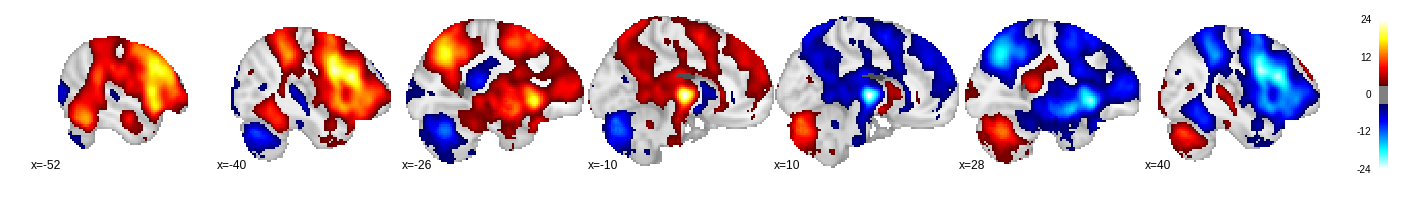

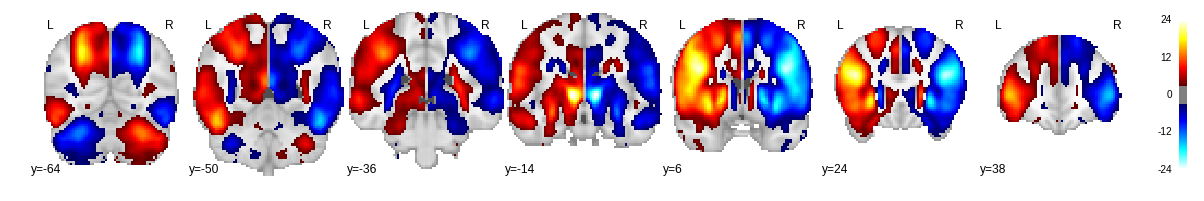

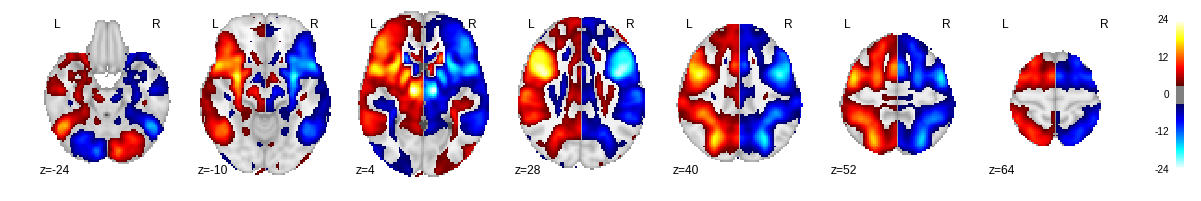

In [81]:
plotting.plot_stat_map(tIm,display_mode='x',threshold=3)
plotting.plot_stat_map(tIm,display_mode='y',threshold=3)
plotting.plot_stat_map(tIm,display_mode='z',threshold=3)

### isolate only one side

get a left hemisphere mask

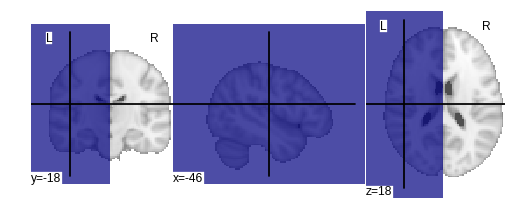

In [82]:
leftHemi = '../data/external/leftHemisphere.nii'
plotting.plot_roi(leftHemi)

combine with MNI brain to make a masker object

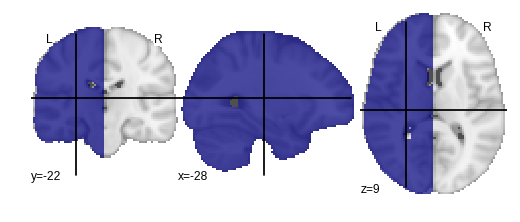

In [83]:
leftMask = masker.inverse_transform(masker.transform(leftHemi))
leftMasker = input_data.NiftiMasker(mask_img=leftMask).fit()

plotting.plot_roi(leftMasker.mask_img_)

get the left side only

In [84]:
leftLangRoi = leftMasker.inverse_transform(leftMasker.transform('../data/processed/nii/tMap_diff_values.nii.gz'))

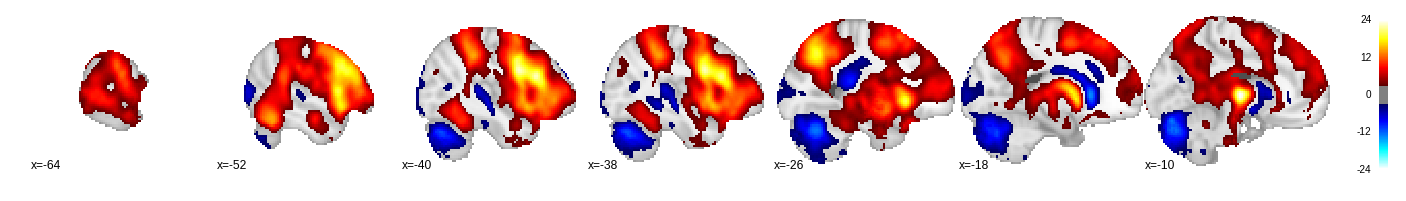

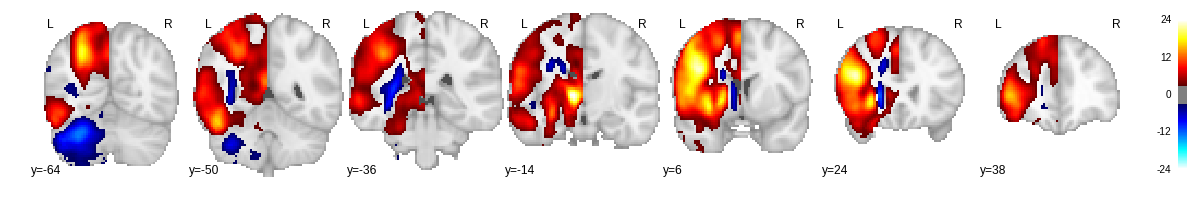

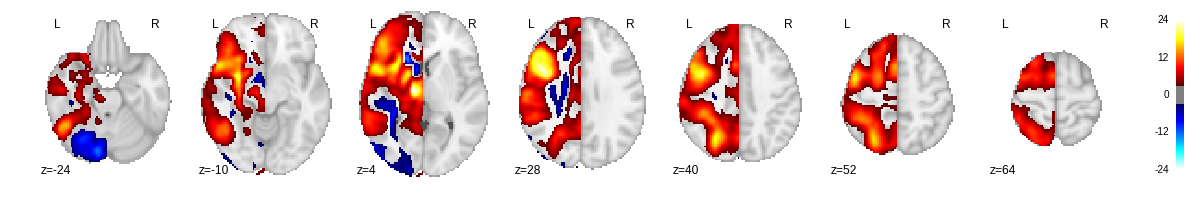

In [85]:
plotting.plot_stat_map(leftLangRoi,display_mode='x',threshold=3)
plotting.plot_stat_map(leftLangRoi,display_mode='y',threshold=3)
plotting.plot_stat_map(leftLangRoi,display_mode='z',threshold=3)

save the mask

In [86]:
# in its original form
leftLangRoi.to_filename('../data/processed/nii/tMap_diff_left.nii.gz')
leftLangRoi.to_filename('../models/tMap_diff_left.nii.gz')
# in its flipped form
data,affine = leftLangRoi.get_data(),leftLangRoi.affine
flipAffine = np.concatenate([ np.array([affine[0]*-1]), affine[1:] ])
flipIm = nib.Nifti1Image(data,flipAffine)

flipIm = masker.inverse_transform(masker.transform(flipIm)) # hack
flipIm.to_filename('../data/processed/nii/tMap_diff_right.nii.gz')
flipIm.to_filename('../models/tMap_diff_right.nii.gz')

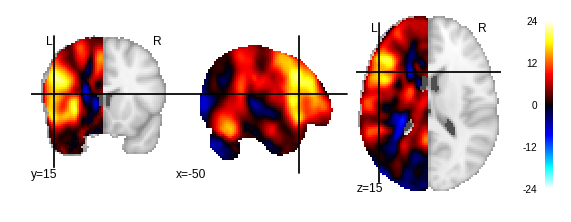

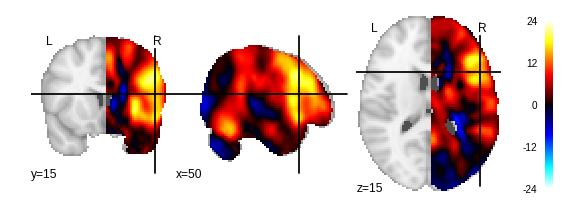

In [87]:
plotting.plot_stat_map('../data/processed/nii/tMap_diff_left.nii.gz',cut_coords=(-50,15,15))
plotting.plot_stat_map('../data/processed/nii/tMap_diff_right.nii.gz',cut_coords=(50,15,15))